# Zadanie 5


Celem ćwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu optymalizacji gradientowej z algorytmem propagacji wstecznej.

Następnie należy wytrenować perceptron wielowarstwowy do klasyfikacji zbioru danych [MNIST](http://yann.lecun.com/exdb/mnist/). Zbiór MNIST dostępny jest w pakiecie `scikit-learn`.

Punktacja:
1. Implementacja propagacji do przodu (`forward`) [1 pkt]
2. Implementacja wstecznej propagacji (zademonstrowana na bramce XOR) (`backward`) [2 pkt]
3. Przeprowadzenie eksperymentów na zbiorze MNIST, w tym:
    1. Porównanie co najmniej dwóch architektur sieci [1 pkt]
    2. Przetestowanie każdej architektury na conajmniej 3 ziarnach [1 pkt]
    3. Wnioski 1.[5 pkt]
4. Jakość kodu 0.[5 pkt]

Polecane źródła - teoria + intuicja:
1. [Karpathy, CS231n Winter 2016: Lecture 4: Backpropagation, Neural Networks 1](https://www.youtube.com/watch?v=i94OvYb6noo&ab_channel=AndrejKarpathy)
2. [3 Blude one Brown, Backpropagation calculus | Chapter 4, Deep learning
](https://www.youtube.com/watch?v=tIeHLnjs5U8&t=4s&ab_channel=3Blue1Brown)


In [ ]:
from abc import abstractmethod, ABC
from typing import List
import numpy as np
import sklearn
import sklearn.model_selection
from sklearn import datasets
from random import randint

In [ ]:
digits = datasets.load_digits()

### Layer abstract

In [ ]:
# Abstract class, can't be instantiated
class Layer(ABC):
    """Basic building block of the Neural Network"""

    def __init__(self) -> None:
        self._learning_rate = 0.01
        # self._learning_rate = 0.1

    @abstractmethod
    def forward(self, x:np.ndarray)->np.ndarray:
        """Forward propagation of x through layer"""
        pass

    @abstractmethod
    def backward(self, output_error_derivative) ->np.ndarray:
        """Backward propagation of output_error_derivative through layer"""
        pass

    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        assert learning_rate < 1, f"Given learning_rate={learning_rate} is larger than 1"
        assert learning_rate > 0, f"Given learning_rate={learning_rate} is smaller than 0"
        self._learning_rate = learning_rate


### Fully Connected

In [ ]:
class FullyConnected(Layer):
    def __init__(self, input_size:int, output_size:int, seed = None) -> None:
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.last_x = []
        self.calc_values = []
        # Initializing with random weights
        if seed != None:
            np.random.seed(seed)
        self.weights = np.random.uniform(low= -0.2, high= 0.2, size=(self.output_size, self.input_size))
        self.biases = np.random.uniform(low=0.0, high=0.3, size=(self.output_size, 1))
        np.random.seed()
        self.weights_changes = np.zeros((self.output_size, self.input_size))
        self.nr_of_weights_changes = 0
        self.biases_changes = np.zeros((self.output_size, 1))
        self.nr_of_biases_changes = 0

    def forward(self, x:np.ndarray)->np.ndarray:
        self.last_x = x
        # Z = WX + B for each neuron
        self.calc_values = np.matmul(self.weights, x) + self.biases
        return self.calc_values

    def backward(self, output_error_derivative)->np.ndarray:
        x_d = np.matmul(self.weights.T, output_error_derivative)
        w_d = np.matmul(output_error_derivative, self.last_x.T)
        b_d = output_error_derivative

        self.weights_changes -= w_d * self.learning_rate
        self.nr_of_weights_changes += 1
        self.biases_changes -= b_d * self.learning_rate
        self.nr_of_biases_changes += 1

        return x_d


In [ ]:
w = np.random.uniform(low= -0.2, high= 0.2, size=(8, 2))
b = np.random.uniform(low=0.0, high=0.3, size=(8, 1))
np.matmul(w, np.array([0,1])), np.matmul(w, np.array([0,1])).T

(array([ 0.16389601,  0.0492048 ,  0.08106032,  0.06112135, -0.09842544,
         0.19166689,  0.06672164,  0.03874481]),
 array([ 0.16389601,  0.0492048 ,  0.08106032,  0.06112135, -0.09842544,
         0.19166689,  0.06672164,  0.03874481]))

### Tanh

In [ ]:
class Tanh(Layer):

    def __init__(self) -> None:
        super().__init__()
        self.last_x = []
        self.calc_values = []

    def forward(self, x:np.ndarray)->np.ndarray:
        self.last_x = x
        self.calc_values = np.tanh(x)
        return self.calc_values

    def backward(self, output_error_derivative)->np.ndarray:
        tanh_d = 1 - np.tanh(self.last_x)*np.tanh(self.last_x)
        return tanh_d * output_error_derivative

### Loss

In [ ]:
class Loss:
    def __init__(self, loss_function:callable, loss_function_derivative:callable)->None:
        self.loss_function = loss_function
        self.loss_function_derivative = loss_function_derivative

    def loss(self, x:np.ndarray, y:np.ndarray)->float:
        """Loss function for a particular x and y"""
        return self.loss_function(x, y)

    def loss_derivative(self, x:np.ndarray, y:np.ndarray)->np.ndarray:
        """Loss function derivative for a particular x and y"""
        return self.loss_function_derivative(x, y)


In [ ]:
def MSE_loss(output:np.ndarray, target:np.ndarray) -> float:
    """ output - array (n,1) of probabilities; target - array (n,1) representing one-hot encoded target class"""
    assert output.shape == target.shape, f"Arrays have to have the same shape"
    diff_array = output - target
    arr_len = output.shape[0]
    return (sum(diff_array * diff_array)[0])/arr_len

def MSE_loss_derivative(output:np.ndarray, target:np.ndarray) -> np.ndarray:
    """ How network output influences loss function """
    arr_len =output.shape[0]
    return (2/arr_len) * (output - target)


def softmax(values):
    values_exp = np.exp(values)
    return values_exp / values_exp.sum(axis=0)

def cross_entropy(output:np.ndarray, target:np.ndarray) -> float:
    output = softmax(output)
    indexes_zero = np.where(output==0.0)[0]
    for index in indexes_zero:
        output[index] += 1.0e-105
    return (-1)*sum(target * np.log(output))[0]

def cross_entropy_derivative(output:np.ndarray, target:np.ndarray) -> np.ndarray:
    softmax_values = softmax(output)
    return softmax_values - target


In [ ]:
def target_to_one_hot(target_nr:int, range_size:int) -> np.ndarray:
    one_hot = np.zeros((range_size,1))
    one_hot[target_nr] = 1.0
    return one_hot

### Network

In [ ]:
class Network:
    def __init__(self, layers:List[Layer], learning_rate:float)->None:
        self.layers = layers
        self.learning_rate = learning_rate
        for layer in layers:
            layer.learning_rate = learning_rate

    def compile(self, loss:Loss)->None:
        """Define the loss function and loss function derivative"""
        self.loss = loss

    def __call__(self, x:np.ndarray) -> np.ndarray:
        """Forward propagation of x through all layers"""
        current_input = x
        for layer in self.layers:
            current_input = layer.forward(current_input)
        return current_input

    def backward(self, case_output, case_target):
        current_error = self.loss.loss_derivative(case_output, case_target)
        for layer in self.layers[::-1]:
            current_error = layer.backward(current_error)

    def update_weights(self):
         for layer in self.layers:
            if isinstance(layer, FullyConnected):
                # Update weights and biases changes
                layer.weights += layer.weights_changes / layer.nr_of_weights_changes
                layer.biases += layer.biases_changes / layer.nr_of_biases_changes
                # Clear weights and biases changes
                layer.weights_changes = np.zeros_like(layer.weights_changes)
                layer.nr_of_weights_changes = 0
                layer.biases_changes = np.zeros_like(layer.biases_changes)
                layer.nr_of_biases_changes = 0


    def test(self, x_test:np.ndarray, y_test:int, output_size:int):
        target_number = y_test
        x_test = np.array([x_test]).T
        y_test = target_to_one_hot(y_test, output_size)
        output = self(x_test)
        output_nr = np.argmax(output)
        loss = self.loss.loss(output, y_test)
        # print("Output: " + str(output_nr) + " Target: " + str(target_number) + " Loss: " + str(loss))
        return (output_nr == target_number)

    def fit(self,
            x_train:np.ndarray,
            y_train:np.ndarray,
            epochs:int,
            batch_size:int,
            output_size:int,
            verbose:int=0)->None:
        """Fit the network to the training data"""
        x_train_len = x_train.shape[0]
        if batch_size == -1:
            batch_size = x_train_len
        epochs_accuracy = []
        for epoch_nr in range(epochs):
            success = 0
            all = 0
            for batch_nr in range((x_train_len // batch_size) + 1):
                batch_x = x_train[batch_nr*batch_size : batch_nr*batch_size + batch_size]
                batch_y = y_train[batch_nr*batch_size : batch_nr*batch_size + batch_size]
                for test_case, case_target in zip(batch_x, batch_y):
                    target_number = case_target
                    test_case = np.array([test_case]).T
                    case_target = target_to_one_hot(case_target, output_size)
                    # Propagate forward
                    case_output = self(test_case)
                    # Calculate loss function
                    case_loss = self.loss.loss(case_output, case_target)
                    # Backpropagete
                    self.backward(case_output, case_target)
                    output_nr = np.argmax(case_output)

                    if output_nr == target_number:
                        success += 1
                    all += 1
                # print("Output: " + str(output_nr) + " Target: " + str(target_number) + " Loss: " + str(loss))
                if batch_x.shape[0] != 0:
                    self.update_weights()
            epochs_accuracy.append(success/all)
        return epochs_accuracy

#### Tworzenie wykresów

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot(x_data, y_data, labels, title):
    # plot
    fig, ax = plt.subplots()
    colors = []
    if len(y_data) <= 3:
        colors = [plt.cm.plasma(i / len(y_data)) for i in range(len(y_data))]
    else:
        colors = [plt.cm.Blues(i / len(y_data)) for i in range(len(y_data))]

    for i in range(len(y_data)):
        ax.plot(x_data, y_data[i], linewidth=2.0, label=labels[i], color = colors[i])

    ax.set(xlim=(0, len(x_data)), xticks=np.arange(0, len(x_data), len(x_data)//10),
           ylim=(0, 1), yticks=np.arange(0,1,0.1),)

    plt.title(title)
    fig.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
    plt.show()

### XOR

In [ ]:
def prepare_xor(data_size, test_ratio, seed = None):
    # TRAINING DATA
    np.random.seed(seed)
    xor_input, xor_output = [], []
    for i in range(data_size):
        case = [np.random.randint(0,2), np.random.randint(0,2)]
        xor_input.append(case)
        output = 1 if case.count(1) == 1 else 0
        xor_output.append(output)
    np.random.seed()

    pivot = len(xor_input) - int(len(xor_input)*test_ratio)
    x_train = np.array(xor_input[:pivot])
    y_train = np.array(xor_output[:pivot])
    x_test = np.array(xor_input[pivot:])
    y_test = np.array(xor_output[pivot:])

    return (x_train, y_train, x_test, y_test)

In [ ]:

# TRAINING
x_train, y_train, x_test, y_test = prepare_xor(200, 0.2)
n = Network([FullyConnected(2, 2, 21), Tanh()], 0.01)
l = Loss(cross_entropy, cross_entropy_derivative)
n.compile(l)
n.fit(x_train, y_train, 60, -1, 2, 0)

# #TESTING
# success = 0
# all = 0
# for x_test_case, y_test_case in zip(x_test, y_test):
#     # print(x_test_case, np.argmax(n(np.array([x_test_case]).T)), y_test_case)
#     if n.test(x_test_case, y_test_case, 2):
#         success += 1
#     all += 1
# print("Accuracy: " + str(success/all))


[0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45,
 0.24375,
 0.24375,
 0.24375,
 0.24375,
 0.24375]

### MNIST

In [ ]:
def prepare_mnist(test_size=0.2, seed=None):
    mnist = sklearn.datasets.load_digits()
    # xs = mnist.data / 16
    x = mnist.data
    y = mnist.target
    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
        x, y, test_size=test_size, random_state=seed
    )
    return (x_train, y_train, x_test, y_test)

In [ ]:
def use_network_mnist(layers, learning_rate = 0.01, epochs = 60, batch_size = 32, test_data_size = 0.2, data_split_seed = None, create_plot = False, verbose=0):
    # Training network
    if verbose:
        print("TRAINING Network")
    mnist_data = prepare_mnist(test_size = test_data_size, seed = data_split_seed)

    n = Network(layers, learning_rate)
    l = Loss(cross_entropy, cross_entropy_derivative)
    n.compile(l)

    epochs_accuracy = n.fit(mnist_data[0], mnist_data[1],
                            epochs, batch_size, 10, 0)
    # Testing network
    if verbose:
        print("TESTING Network")
    success = 0
    all = 0
    for x_test, y_test in zip(mnist_data[2], mnist_data[3]):
        if all == 0:
            print(n(np.array([x_test]).T))
        if n.test(x_test, y_test, 10):
            success += 1
        all += 1
    test_accuracy = success/all
    if verbose:
        print("Accuracy: " + str(test_accuracy))

    #Creating plots
    if create_plot:
        plot(list(range(0,epochs)), [epochs_accuracy, np.full_like(epochs_accuracy, test_accuracy)], ["Dokładność w czasie", "Dokładność na zbiorze testowym"], "Dokładność sieci")

    return (epochs_accuracy, test_accuracy)


Example use

TRAINING Network
TESTING Network
[[-0.99999644]
 [-0.94509733]
 [ 1.        ]
 [-0.99979916]
 [-0.99995865]
 [ 0.9764818 ]
 [-0.99972087]
 [-0.99661147]
 [-0.99828512]
 [-0.99996412]]
Accuracy: 0.20555555555555555


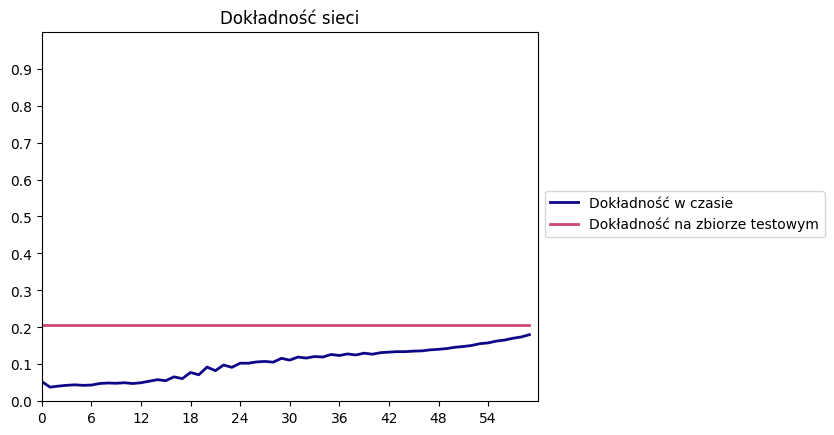

In [ ]:
_ = use_network_mnist([FullyConnected(64, 30, 39), FullyConnected(30, 10, 12), Tanh()], 0.05, 60, -1, 0.2, 34, True, 1)

TRAINING Network
TESTING Network
Accuracy: 0.8277777777777777
2


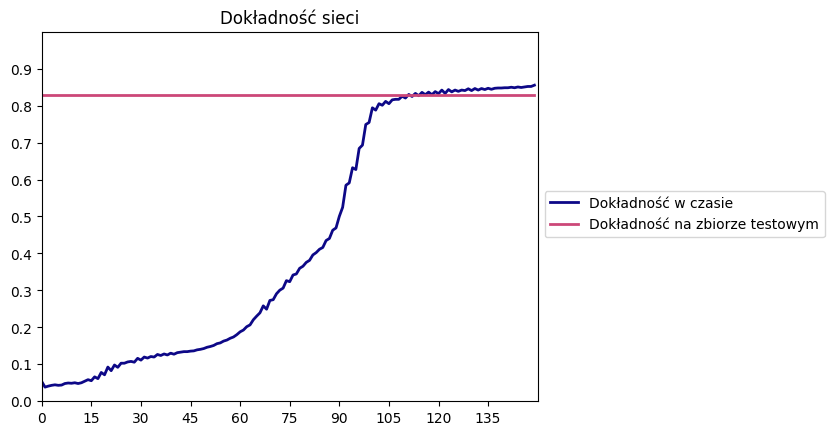

In [ ]:
_ = use_network_mnist([FullyConnected(64, 30, 39), FullyConnected(30, 10, 12), Tanh()], 0.05, 150, -1, 0.2, 34, True, 1)

# Architektura 1

Dokładność w czasie dla różnych ziaren

11


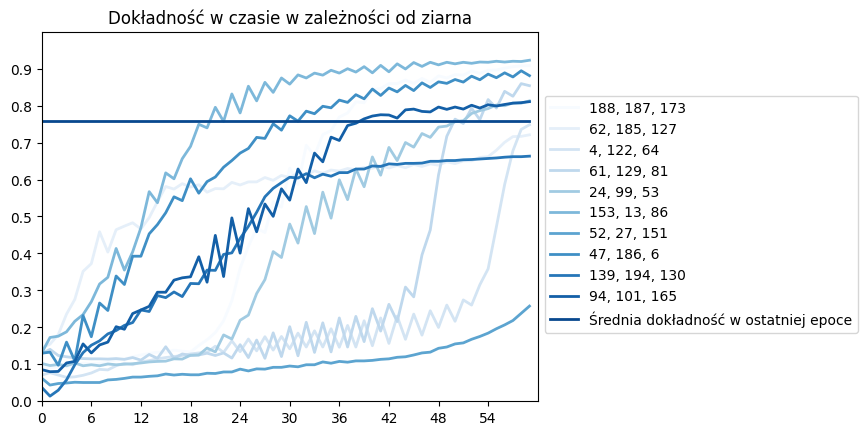

In [ ]:
epochs = 60
plot_x, plot_y, labels = list(range(0,epochs)), [], []
avg_final_accuracy = []

seeds = [(188, 187, 173),(62, 185, 127),(4, 122, 64),(61, 129, 81),(24, 99, 53),(153, 13, 86),(52, 27, 151),(47, 186, 6),(139, 194, 130),(94, 101, 165)]
for i in range(10):
    epochs_accuracy, test_accuracy = use_network_mnist([FullyConnected(64, 30, seeds[i][0]), FullyConnected(30, 10, seeds[i][1]), Tanh()], 0.05, epochs, -1, 0.2, seeds[i][2], False, 0)
    plot_y.append(epochs_accuracy)
    labels.append(str(seeds[i][0]) + ", " + str(seeds[i][1]) + ", " + str(seeds[i][2]))
    avg_final_accuracy.append(epochs_accuracy[-1])

plot_y.append(np.full_like(epochs_accuracy, sum(avg_final_accuracy)/len(avg_final_accuracy)))
labels.append("Średnia dokładność w ostatniej epoce")

plot(plot_x, plot_y, labels, "Dokładność w czasie dla różnych ziaren")

Dokładność w czasie w zależności od learning rate, dla jednego ziarna

11


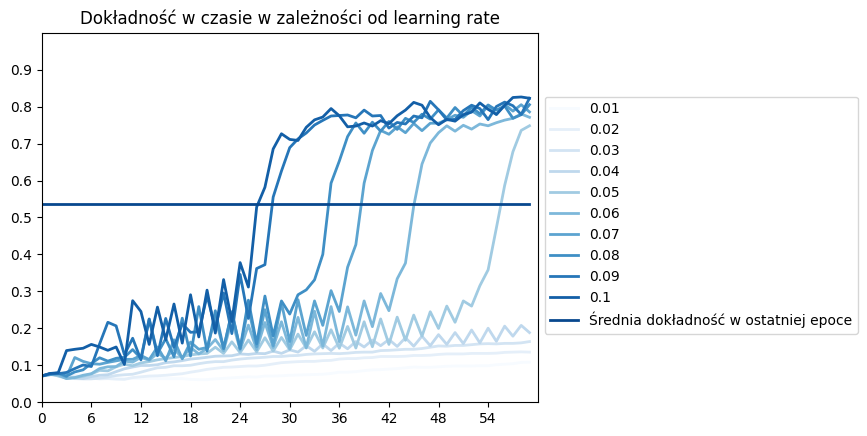

In [ ]:
epochs = 60
plot_x, plot_y, labels = list(range(0,epochs)), [], []
avg_final_accuracy = []

seed = (4, 122, 64)
for i in range(10):
    learning_rate = 0.01*(i+1)
    epochs_accuracy, test_accuracy = use_network_mnist([FullyConnected(64, 30, seed[0]), FullyConnected(30, 10, seed[1]), Tanh()], learning_rate, epochs, -1, 0.2, seed[2], False,0)
    plot_y.append(epochs_accuracy)
    labels.append(str(learning_rate))
    avg_final_accuracy.append(epochs_accuracy[-1])

plot_y.append(np.full_like(epochs_accuracy, sum(avg_final_accuracy)/len(avg_final_accuracy)))
labels.append("Średnia dokładność w ostatniej epoce")

plot(plot_x, plot_y, labels, "Dokładność w czasie w zależności od learning rate")

Dokładność w czasie w zależności od learning rate, średnia dla wielu ziaren

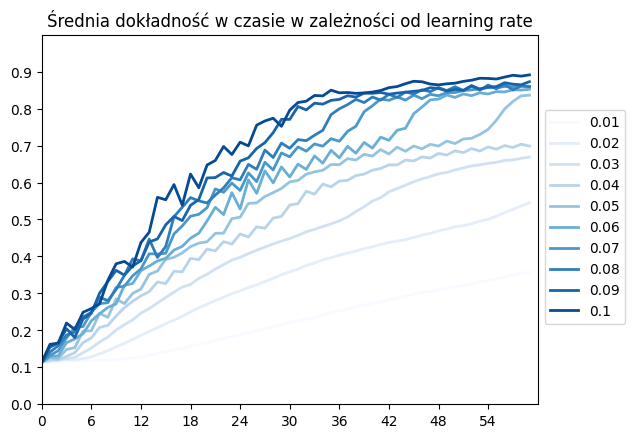

In [ ]:
epochs = 60
plot_x, plot_y, labels = list(range(0,epochs)), None, None
avg_final_accuracy = []
avg_epochs_accuracy = np.zeros((10,epochs))

seeds = [(188, 187, 173),(62, 185, 127),(4, 122, 64),(153, 13, 86),(47, 186, 6)]
for i in range(len(seeds)):
    for j in range(10):
        learning_rate = 0.01*(j+1)
        epochs_accuracy, test_accuracy = use_network_mnist([FullyConnected(64, 30, seeds[i][0]), FullyConnected(30, 10, seeds[i][1]), Tanh()], learning_rate, epochs, -1, 0.2, seeds[i][2], False, 0)
        avg_epochs_accuracy[j] += np.array(epochs_accuracy)
avg_epochs_accuracy = avg_epochs_accuracy/len(seeds)

plot_y = [list(lr_case) for lr_case in avg_epochs_accuracy]
labels = [str(0.01*(j+1)) for j in range(10)]

plot(plot_x, plot_y, labels, "Średnia dokładność w czasie w zależności od learning rate")

Dokładność w czasie w zależności od liczby epok

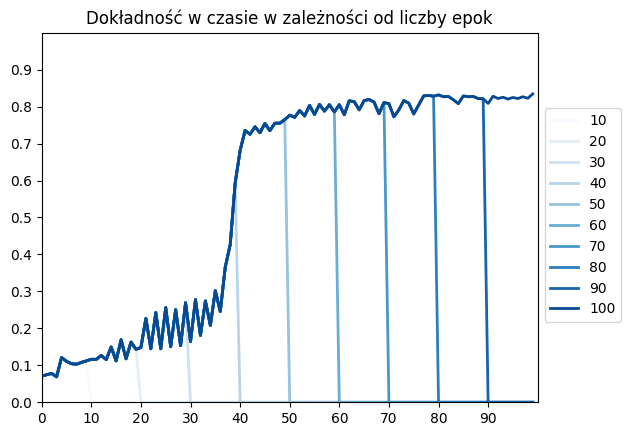

In [ ]:
plot_y, labels = [], []
avg_final_accuracy = []

seed = (4, 122, 64)
for i in range(10):
    nr_of_epochs = 10*(i+1)
    epochs_accuracy, test_accuracy = use_network_mnist([FullyConnected(64, 30, seed[0]), FullyConnected(30, 10, seed[1]), Tanh()], 0.07, nr_of_epochs, -1, 0.2, seed[2], False, 0)
    plot_y.append(epochs_accuracy + [0]*(100 - len(epochs_accuracy)))
    labels.append(str(nr_of_epochs))
    avg_final_accuracy.append(epochs_accuracy[-1])

plot_x = list(range(0, 100))

plot(plot_x, plot_y, labels, "Dokładność w czasie w zależności od liczby epok")

# Architektura 2

Dokładność w czasie dla różnych ziaren

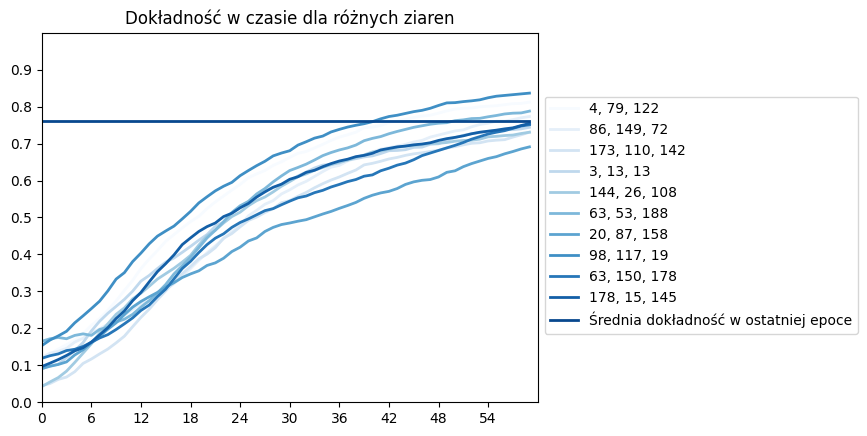

In [ ]:
epochs = 60
plot_x, plot_y, labels = list(range(0,epochs)), [], []
avg_final_accuracy = []

seeds = [(4, 79, 122, 173),(86, 149, 72, 127),(173, 110, 142, 64),(3, 13, 13, 81),(144, 26, 108, 53),(63, 53, 188, 86),(20, 87, 158, 151),(98, 117, 19, 6),(63, 150, 178, 130),(178, 15, 145, 165)]
for i in range(10):
    epochs_accuracy, test_accuracy = use_network_mnist([FullyConnected(64, 40, seeds[i][0]), Tanh(), FullyConnected(40, 20, seeds[i][1]), Tanh(), FullyConnected(20, 10, seeds[i][2]), Tanh()], 0.05, epochs, -1, 0.2, seeds[i][3], False, 0)
    plot_y.append(epochs_accuracy)
    labels.append(str(seeds[i][0]) + ", " + str(seeds[i][1]) + ", " + str(seeds[i][2]))
    avg_final_accuracy.append(epochs_accuracy[-1])

plot_y.append(np.full_like(epochs_accuracy, sum(avg_final_accuracy)/len(avg_final_accuracy)))
labels.append("Średnia dokładność w ostatniej epoce")

plot(plot_x, plot_y, labels, "Dokładność w czasie dla różnych ziaren")

Dokładność w czasie w zależności od learning rate, dla jednego ziarna

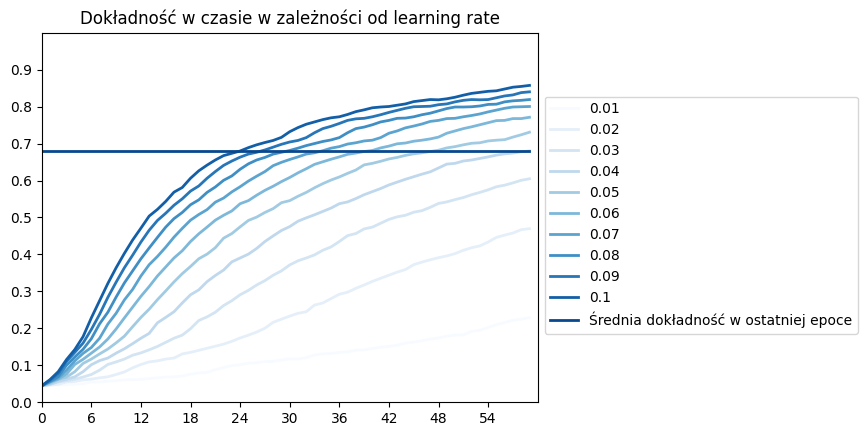

In [ ]:
epochs = 60
plot_x, plot_y, labels = list(range(0,epochs)), [], []
avg_final_accuracy = []

seed = (173, 110, 142, 64)
for i in range(10):
    learning_rate = 0.01*(i+1)
    epochs_accuracy, test_accuracy = use_network_mnist([FullyConnected(64, 40, seed[0]), Tanh(), FullyConnected(40, 20, seed[1]), Tanh(), FullyConnected(20, 10, seed[2]), Tanh()], learning_rate, epochs, -1, 0.2, seed[3], False, 0)
    plot_y.append(epochs_accuracy)
    labels.append(str(learning_rate))
    avg_final_accuracy.append(epochs_accuracy[-1])

plot_y.append(np.full_like(epochs_accuracy, sum(avg_final_accuracy)/len(avg_final_accuracy)))
labels.append("Średnia dokładność w ostatniej epoce")

plot(plot_x, plot_y, labels, "Dokładność w czasie w zależności od learning rate")

Dokładność w czasie w zależności od learning rate, średnia dla wielu ziaren

In [ ]:
epochs = 60
plot_x, plot_y, labels = list(range(0,epochs)), None, None
avg_final_accuracy = []
avg_epochs_accuracy = np.zeros((10,epochs))

seeds = [(4, 79, 122, 173),(86, 149, 72, 127),(173, 110, 142, 64),(63, 53, 188, 86),(98, 117, 19, 6)]

for i in range(len(seeds)):
    for j in range(10):
        learning_rate = 0.01*(j+1)
        epochs_accuracy, test_accuracy = use_network_mnist([FullyConnected(64, 40, seeds[i][0]), Tanh(), FullyConnected(40, 20, seeds[i][1]), Tanh(), FullyConnected(20, 10, seeds[i][2]), Tanh()],
                                                           learning_rate, epochs, -1, 0.2, seeds[i][3], False, 0)
        avg_epochs_accuracy[j] += np.array(epochs_accuracy)
avg_epochs_accuracy = avg_epochs_accuracy/len(seeds)

plot_y = [list(lr_case) for lr_case in avg_epochs_accuracy]
labels = [str(0.01*(j+1)) for j in range(10)]
plot(plot_x, plot_y, labels, "Średnia dokładność w czasie w zależności od learning rate")

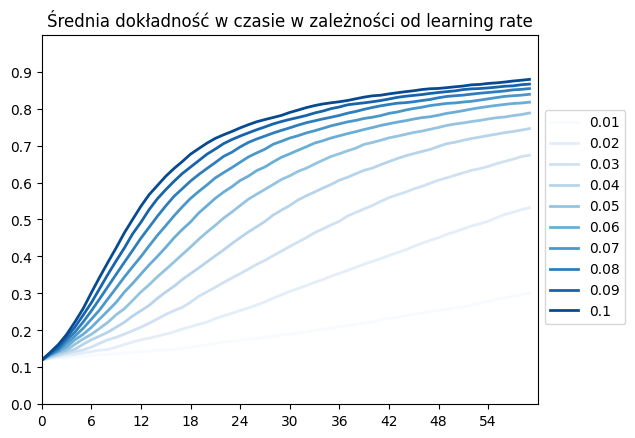

Dokładność w czasie w zależności od liczby epok

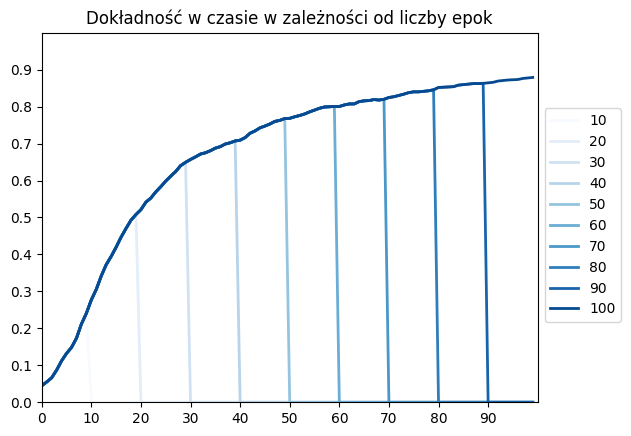

In [ ]:
plot_y, labels = [], []
avg_final_accuracy = []

seed = (173, 110, 142, 64)
for i in range(10):
    nr_of_epochs = 10*(i+1)
    epochs_accuracy, test_accuracy = use_network_mnist([FullyConnected(64, 40, seed[0]), Tanh(), FullyConnected(40, 20, seed[1]), Tanh(), FullyConnected(20, 10, seed[2]), Tanh()],
                                                       0.07, nr_of_epochs, -1, 0.2, seed[3], False, 0)
    plot_y.append(epochs_accuracy + [0]*(100 - len(epochs_accuracy)))
    labels.append(str(nr_of_epochs))
    avg_final_accuracy.append(epochs_accuracy[-1])

plot_x = list(range(0, 100))

plot(plot_x, plot_y, labels, "Dokładność w czasie w zależności od liczby epok")

### Porównanie architektur

TRAINING Network
TESTING Network
Accuracy: 0.8638888888888889


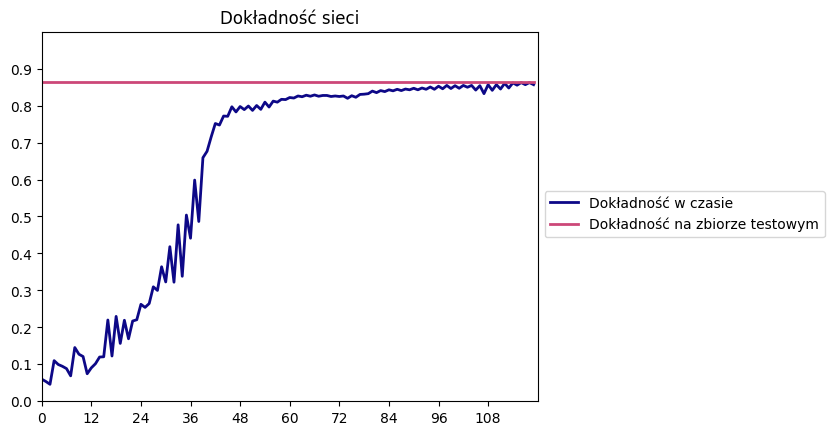

In [ ]:
_ = use_network_mnist([FullyConnected(64, 30, 39), FullyConnected(30, 10, 12), Tanh()], 0.1, 120, -1, 0.2, 5, True, 1)

TRAINING Network
TESTING Network
Accuracy: 0.925


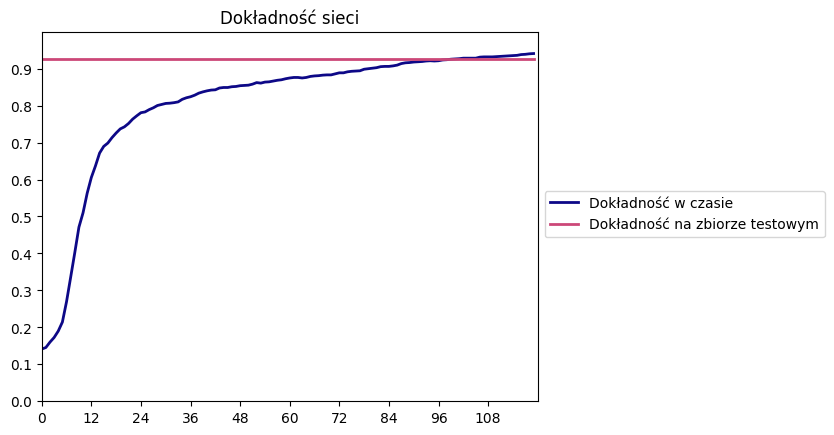

In [ ]:
_ = use_network_mnist([FullyConnected(64, 40, 39), Tanh(), FullyConnected(40, 20, 97), Tanh(), FullyConnected(20, 10, 12), Tanh()], 0.1, 120, -1, 0.2, 5, True, 1)

In [ ]:
# from random import randint

# seeds = [(188, 187, 173),(62, 185, 127),(4, 122, 64),(61, 129, 81),(24, 99, 53),(153, 13, 86),(52, 27, 151),(47, 186, 6),(139, 194, 130),(94, 101, 165)]
# l = []
# for i in range(10):
#     l.append((randint(0,200), randint(0,200), randint(0,200), seeds[i][2]))
# l

# Wnioski

In [ ]:
a = FullyConnected(3, 4)
y_a = a.forward(np.array([1,2,3]))

b = Tanh()
y_b = b.forward(y_a)

y_a, y_b

(array([1.09301416, 0.74523748, 0.88373921, 0.63443646]),
 array([0.89898781, 0.81614955, 0.85414381, 0.78054975]))

In [ ]:
# tan1 = Tanh()
# fc1 = FullyConnected(64, 10)
# netw = Network([fc1, tan1], 0.1)

# loss = Loss(loss_function, loss_derivative)
# netw.compile(loss)

# output = netw.__call__(digits.data[0])

# target_one_hot = np.zeros((10,))
# target_one_hot[digits.target[0]] = 1.0
# loss.loss_single(output, target_one_hot)

# b1 = loss.loss_derivative(output, target_one_hot)
# b2 = tan1.backward(b1)
# b3 = fc1.backward(b2)
# # b3